In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# # Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import  process_data, get_train_and_val_loader, get_base_tensor_directories

# import all the models from models module
from models import Swin_Transformer
# from util.video_swin_transformer import SwinTransformer3D
import torch.optim.lr_scheduler as lr_scheduler

import warnings

device = get_device()

EXTRACT_DATA = False

c:\Users\ahmed\anaconda3\envs\vstp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7'


You are using device: cpu


In [2]:
if EXTRACT_DATA:
    # # Data inputs for CNN and Swin Transformer baseline
    # disable pyav warning
    warnings.filterwarnings("ignore", message="Accurate seek is not implemented for pyav backend")
    process_data(
        input_type='video_pack_1000_swin', 
        # addition_parameters={'first_n_videos': 10}, 
        verbose=False,
        device=get_device(),
        skip_frames=True,
        frames_to_skip=200,
        resize_tensors=True,
        uniform_frames=True,
        set_frame_count=20,
        shrink=8,
        clean_dir=True
    )

In [3]:
device = get_device()
train_loader, val_loader, scaler = get_train_and_val_loader(
    input_type='video_pack_1000_swin',
    batch_size=15,
    verbose=True,
    scale_target=True,
    # tensor_upper_limit=10
)

You are using device: cpu
torch.Size([3, 20, 128, 72])
torch.Size([3, 20, 128, 72])
800
200


In [4]:
# linear_in_dim work for default network with frames input uniform at 100 and HxW at 1024x576
# model = Swin_Transformer.Swin_Transformer_model(linear_in_dim=768*25*32*18)
# linear_in_dim work for default network with frames input uniform at 15 and HxW at 128x72
model = Swin_Transformer.Swin_Transformer_model(
    # patch_size=(2,2,2), 
    # num_heads=[6, 12, 24, 48],
    # depths=[4, 4, 12, 4],
    drop_rate=0.1,
    patch_norm=True,
    linear_in_dim=46080,
    scaled_target=True
) # .train(mode=True)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.00001,
    weight_decay=0.0001)

print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1/3, total_iters=10, verbose=True)

EPOCHS = 20

train_losses = []
val_losses = []

Swin_Transformer_model(
  (swin_transformer): SwinTransformer3D(
    (patch_embed): PatchEmbed3D(
      (proj): Conv3d(3, 96, kernel_size=(4, 4, 4), stride=(4, 4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock3D(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention3D(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.1, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_fea

c:\Users\ahmed\anaconda3\envs\vstp\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer, device, verbose=True)
    
    # model.train(mode=False)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion, device, verbose=True)
    
    # scheduler.step()
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')




Forward pass on batch with size: torch.Size([15, 3, 20, 128, 72])
Model Output (shape: torch.Size([15, 1])): tensor([[ 1.0873],
        [-0.1607],
        [ 0.7686],
        [ 0.0432],
        [-0.5224],
        [ 0.1600],
        [-0.2996],
        [-0.6774],
        [ 0.1186],
        [ 0.0770],
        [-0.5198],
        [ 0.1649],
        [ 0.3620],
        [-0.1846],
        [ 0.3828]], grad_fn=<AddmmBackward0>)
Target (shape: torch.Size([15, 1])): tensor([[-0.3480],
        [-0.2889],
        [-0.3445],
        [-0.3524],
        [-0.1780],
        [-0.1832],
        [-0.1357],
        [ 0.7621],
        [-0.3330],
        [-0.3140],
        [-0.2889],
        [ 0.1637],
        [-0.3522],
        [-0.3162],
        [-0.2941]])


Forward pass on batch with size: torch.Size([15, 3, 20, 128, 72])
Model Output (shape: torch.Size([15, 1])): tensor([[-1.3717],
        [-1.5208],
        [-1.4906],
        [-1.1149],
        [-1.8710],
        [-1.6006],
        [-1.9170],
        [-

In [6]:
# save model if better or not exists
model_weights = {'model_state_dict': model.state_dict(), 'val_loss': avg_val_loss}
weights_file = '../models/save/SWIN_scaled_weights.pt'
if not os.path.isfile(weights_file):
    # save new
    torch.save(model_weights, weights_file)
elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
    # replace
    torch.save(model_weights, weights_file)

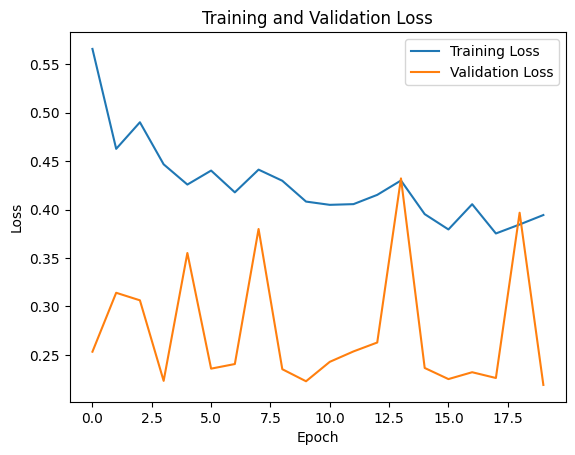

In [7]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    model.eval()
    inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

In [9]:
val_values = scaler.inverse_transform(val_values)
predicted_values = scaler.inverse_transform(predicted_values)

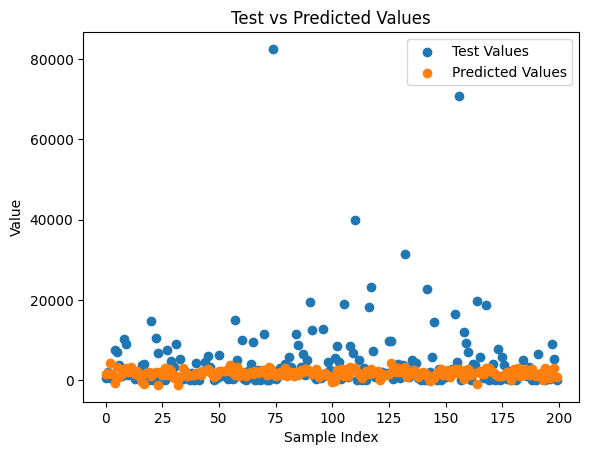

In [10]:
import matplotlib.pyplot as plt

plt.scatter(range(len(val_values)), val_values, label='Test Values')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [11]:
for i in range(len(predicted_values)):
    print(f'Test value: {val_values[i]}, Predicted Value: {predicted_values[i]}')

Test value: [462.39972373], Predicted Value: [1590.56516907]
Test value: [2099.99989582], Predicted Value: [1768.02167973]
Test value: [413.79990023], Predicted Value: [4266.01536206]
Test value: [855.69994656], Predicted Value: [1524.82053324]
Test value: [7500.00002831], Predicted Value: [-623.34189055]
Test value: [7100.00001197], Predicted Value: [3157.36885187]
Test value: [3700.00010229], Predicted Value: [810.26486772]
Test value: [1099.99983732], Predicted Value: [1427.07518223]
Test value: [10300.00003692], Predicted Value: [2782.46963281]
Test value: [9000.00004552], Predicted Value: [3114.14649839]
Test value: [1399.9999113], Predicted Value: [1908.19594075]
Test value: [2200.00001454], Predicted Value: [3302.11754588]
Test value: [2000.00005927], Predicted Value: [2377.59788906]
Test value: [178.40000733], Predicted Value: [1593.47314504]
Test value: [1399.9999113], Predicted Value: [2245.19497233]
Test value: [1499.99974786], Predicted Value: [784.16362485]
Test value: [37

In [12]:
import numpy as np

model_mae = np.absolute(np.subtract(val_values, predicted_values)).mean()
model_mae

4255.277014680162

In [13]:
training_targets = []
for inputs, targets in train_loader:
    training_targets.extend([i.item() for i in targets])

training_targets = np.array(training_targets).reshape(-1, 1)
training_targets = scaler.inverse_transform(training_targets)
training_mean_as_prediction = training_targets.mean()
training_mean_as_predicted_values = [training_mean_as_prediction for i in range(len(predicted_values))]
training_mean_mae = np.absolute(np.subtract(val_values, training_mean_as_predicted_values)).mean()
training_mean_mae


6154.229250699441

In [14]:
model_mae < training_mean_mae

True